<a href="https://colab.research.google.com/github/katha815/ADME-Classifier/blob/main/Data_size_esitimating_loop_(for_higher_accuracy).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialization
Feature groups: (1)6 phastCons scores, (2)6 phyloP scores, (3)vepDistance, (4){A-C,A-G,A-T,C-A,...}categorical input, (5)Ensemble search consequence , (6)corresponding SIFT and Polyphen scores, (7) popoulation frequencies.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
!pip install scikit-optimize
import skopt
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skopt.space import Real, Categorical, Integer

Mounted at /content/gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 882.9 kB/s eta 0:00:00


In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

## Data loading and testing/training split preparation

###Odata

In [ ]:
# Import data
data2 = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/Odata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {data2}\n")
Y = data2['Label']
X = data2[[col for col in data2.columns if col!="Location1" and col!="Location2" and
           col!="chr" and col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(Y,'\n')

Whole data:     Chromo  Location1  Location2 Ref Alter  Label  chr  transcript_ablation  \
0     chr1   46930150   46930150   C     T      1    1                    0   
1     chr1   46930161   46930161   G     A      1    1                    0   
2     chr1   46932824   46932824   T     C      1    1                    0   
3     chr1   46932987   46932987   C     T      1    1                    0   
4     chr1   46934207   46934207   A     G      0    1                    0   
..     ...        ...        ...  ..   ...    ...  ...                  ...   
329  chr22   42129836   42129836   C     T      0   22                    0   
330  chr22   42130692   42130692   C     T      1   22                    0   
331  chr22   42130710   42130710   C     T      0   22                    0   
332  chr22   42130715   42130715   G     A      1   22                    0   
333  chr22   42130761   42130761   G     A      1   22                    0   

     splice_acceptor_variant  splice_do

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = X['Chromo'].unique()
grouped = X.groupby(['Chromo'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist = [None for _ in range(chrom_values.shape[0])]
trainlist = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist[i])}\n")
    # print(f"Test indexes: {testlist[i]}\n")
    # Label: {labels[i]}\n {type(testlist[i])}\n")
testlist10 = testlist
sp1 = [len(x) for x in testlist10]
print(sp1)

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist)) < 20 and len(testlist) > 1:
    idx1, idx2 = sorted(range(len(testlist)), key=lambda i: len(testlist[i]))[:2] #not including 2, so 0/1
    print(testlist[idx1], testlist[idx2])
    testlist[idx1] = testlist[idx1] + testlist[idx2]
    testlist.pop(idx2)
# Check merged-testing sets length:
for x in testlist:
    print(f"Test size: {len(x)};")
sp2 = [len(x) for x in testlist]
print(sp2)

# Validation list: order = order+1 for the testlist
vlist = testlist[1:] + [testlist[0]]
for x in vlist:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(X)))
# print(all)
trainlist = []
for i, test_indexes in enumerate(testlist):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist.append(train_indexes)
for x in trainlist:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist[i])}\n")
    # print(f"Train indexes: {trainlist[i]}\n {type(trainlist[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (18,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Chromosome: chr1:
Data_size: 18
Chromosome: chr2:
Data_size: 28
Chromosome: chr3:
Data_size: 8
Chromosome: chr4:
Data_size: 8
Chromosome: chr6:
Data_size: 42
Chromosome: chr7:
Data_size: 11
Chromosome: chr8:
Data_size: 29
Chromosome: chr9:
Data_size: 1
Chromosome: chr10:
Data_size: 87
Chromosome: chr11:
Data_size: 5
Chromosome: chr12:
Data_size: 2
Chromosome: chr13:
Data_size: 4
Chromosome: chr15:
Data_size: 17
Chromosome: chr16:
Data_size: 17
Chromosome: chr17:
Data_size: 7
Chromosome: chr19:
Data_size: 30
Chromosome: chr20:
Data_size: 3
Chromosome: chr22:
Data_size: 17
[18, 28, 8, 8, 42, 11, 29, 1, 87, 5, 2, 4, 17, 17, 7, 30, 3, 17]
[144] [237, 238]
[144, 237, 238] [314, 315, 316]
[239, 240, 241, 242] [232, 233, 234, 235, 236]
[144, 237, 238, 314, 315, 316] [277, 278, 279, 280, 281, 282, 283]
[46, 47, 48, 49, 50, 51, 52, 53] [54, 55, 56, 57, 58, 59, 60, 61]
[239, 240,

In [ ]:
updated_trainlist = []
for i, test_indexes in enumerate(trainlist):
    v_indexes = vlist[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist.append(updated_test_indexes)
for x in updated_trainlist:
    print(f"Train size: {len(x)};")

Train size: 264;
Train size: 263;
Train size: 276;
Train size: 218;
Train size: 227;
Train size: 280;
Train size: 270;
Train size: 269;
Train size: 271;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
X = X.drop('Chromo', axis=1)
X = np.array([X.values.tolist()]).reshape(X.shape[0],-1)
Y = np.array([Y.values.tolist()]).reshape(X.shape[0],)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
base = "/content/gdrive/My Drive/Colab Notebooks/ADME Project/"

###GKBdata

In [ ]:
# Import data
gkb = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ADME Project/GKBdata_fzero.csv")
# One hot encode with get_dummies
print(f"Whole data: {gkb}\n")
gkb_Y = gkb['Label']
gkb_X = gkb[[col for col in gkb.columns if col!="Location1" and col!="Location2" and
           col!="Label" and col!="Ref" and col!="Alter"and col!="baseChange"]]
print(gkb_X,'\n')
pd.set_option('display.max_rows', None)  # Set the max_rows option to None to show all rows
pd.set_option('display.max_columns', None)  # Set the max_columns option to None to show all columns
print(gkb_X.dtypes,'\n')
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
print(gkb_Y,'\n')

Whole data:      chr  Location1 Ref Alter  transcript_ablation  splice_acceptor_variant  \
0      1   97057448   G     A                    0                        0   
1      1   97073844   G     A                    0                        0   
2      1   97077914   T     C                    0                        0   
3      1   97078076   A     G                    0                        0   
4      1   97078196   G     A                    0                        0   
..   ...        ...  ..   ...                  ...                      ...   
695   22   42129033   C     T                    0                        0   
696   22   42130692   G     A                    0                        0   
697   22   42130718   C     T                    0                        0   
698   22   42131289   G     T                    0                        0   
699   22   42132375   G     C                    0                        0   

     splice_donor_variant  stop_gained 

In [ ]:
## Prepare leave one chromosome out split indexes
chrom_values = gkb_X['chr'].unique()
grouped = gkb_X.groupby(['chr'])

# Initialization
datasplit = []
labels = []
combined_index = [None for _ in range(chrom_values.shape[0])]
testlist2 = [None for _ in range(chrom_values.shape[0])]
trainlist2 = [None for _ in range(chrom_values.shape[0])]

# Extract info from grouped data
for n in range(chrom_values.shape[0]):
    chrom_i = chrom_values[n]
    new_data = grouped.get_group(chrom_i)  # Generate random data
    label = f"{chrom_i}"  # Generate label
    datasplit.append(new_data)  # Store data
    labels.append(label)  # Store label
print(type(datasplit[0].index),np.shape(datasplit[0].index))
print(datasplit[0].index.tolist())

# Convert it to chromo label and chromo-splitted testing sets
for i in range(len(labels)):
    print(f"Chromosome: {labels[i]}:")
    # print(f"Iteration: {i+1}\n")
    # print(f"Data_index: {datasplit[i].index}")
    print(f"Data_size: {len(datasplit[i])}")
    testlist2[i] = np.array(datasplit[i].index).tolist()
    # print(f"Test size: {len(testlist2[i])}\n")
    print(f"Test indexes: {testlist2[i]}\n")
    # Label: {labels[i]}\n {type(testlist2[i])}\n")
sp3 = [len(x) for x in testlist2]
print(sp3)

# Always merge the shortest lists, make sure the minimum length<20
while min(map(len, testlist2)) < 20 and len(testlist2) > 1:
    idx1, idx2 = sorted(range(len(testlist2)), key=lambda i: len(testlist2[i]))[:2] #not including 2, so 0/1
    print(testlist2[idx1], testlist2[idx2])
    testlist2[idx1] = testlist2[idx1] + testlist2[idx2]
    testlist2.pop(idx2)
# Check merged-testing sets length:
for x in testlist2:
    print(f"Test size: {len(x)};")
sp4 = [len(x) for x in testlist2]
print(sp4)

# Validation list: order = order+1 for the testlist2
vlist2 = testlist2[1:] + [testlist2[0]]
for x in vlist2:
    print(f"Validation size: {len(x)};")

# Build training sets accordingly
all = list(range(len(gkb_X)))
# print(all)
trainlist2 = []
for i, test_indexes in enumerate(testlist2):
    train_indexes = np.array([index for index in all if index not in test_indexes])
    trainlist2.append(train_indexes)
for x in trainlist2:
    print(f"Train size: {len(x)};")
    # print(f"Train size: {len(trainlist2[i])}\n")
    # print(f"Train indexes: {trainlist2[i]}\n {type(trainlist2[i])}\n")

<class 'pandas.core.indexes.numeric.Int64Index'> (136,)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357]
Chromosome: 1:
Data_size: 136
Test indexes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84

In [ ]:
updated_trainlist2 = []
for i, test_indexes in enumerate(trainlist2):
    v_indexes = vlist2[i]
    updated_test_indexes = np.array([index for index in test_indexes if index not in v_indexes])
    updated_trainlist2.append(updated_test_indexes)
for x in updated_trainlist2:
    print(f"Train size: {len(x)};")

Train size: 502;
Train size: 587;
Train size: 566;
Train size: 586;
Train size: 548;
Train size: 542;
Train size: 625;
Train size: 631;
Train size: 599;
Train size: 590;
Train size: 524;


In [ ]:
# Finalizing with scaling
from sklearn.preprocessing import StandardScaler
gkb_X = gkb_X.drop('chr', axis=1)
gkb_X = np.array([gkb_X.values.tolist()]).reshape(gkb_X.shape[0],-1)
gkb_Y = np.array([gkb_Y.values.tolist()]).reshape(gkb_X.shape[0],)
scaler = StandardScaler()
gkb_X = scaler.fit_transform(gkb_X)

## Objectives
1. Data size estimation for 90% accurancy?
2. Active learning/sequential learning to find outliner data points

## Sequential Learning Principal

**Old code**: does not apply LOCO split, but divide the training data into positive/negative groups, and increase the training size by 10 for each iteration.\
**New algorithm 1**: use Packed LOCO split, add the training number by each split.
\
-Test the loop for different "holdout" dataset (use vlist and vlist2) after the first run is finished.\
**New algorithm 2**: As each fold has more than 20 elements, start training from 1/20 of each folds, test it with corresponding "holdout" dataset.

## Data Size Esitmation - XG

In [ ]:
from sklearn.utils import shuffle #Old

Old: Algorithm desgin (following SAYAN 2003 paper): for each selected data size, fit the model and compute acc for 50 times and compare with the random classifier for 1 time; calculate the significance level with the 1*50 comparisons.

In [ ]:
for n in range(2,len(testlist)):
  sublist = testlist[:n]
  flattened_list = [num for sub in sublist for num in sub]
  print(flattened_list)

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 

In [ ]:
def create_xgboost_model(learning_rate, max_depth, n_estimators, min_child_weight, subsample, gamma, reg_alpha):
    model = xgb.XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        n_estimators=int(n_estimators),
        min_child_weight=min_child_weight,
        subsample=subsample,
        gamma=gamma,
        reg_alpha=reg_alpha,
        # reg_lambda=reg_lambda,
        objective='binary:logistic',
        random_state=42
    )
    return model
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'max_depth': (1, 10),
    'n_estimators': (50, 1000),
    'min_child_weight': (1, 20),# = min samples leaf in GB
    'subsample': (0.1, 1.0, 'uniform'),
    'gamma': (0, 1.0, 'uniform'),
    #gamma [default=0, alias: min_split_loss]
    # Minimum loss reduction required to make a further partition on a leaf node of the tree.
    # The larger gamma is, the more conservative the algorithm will be.range: [0,∞]
    'reg_alpha': (0, 1.0, 'uniform') #alpha [default=0, alias: reg_alpha]
    #L1 regularization term on weights. Increasing this value will make model more conservative.range: [0, infinity]
}

In [ ]:
len(testlist)

9

### Trial 1 - graphs not explainable

In [ ]:
# Trial 1
from sklearn.model_selection import PredefinedSplit
import csv
base_path1 = f"{base}dataS/"
acc_scores = []
auc_scores = []
size = []
#0 Use different holdout/testing data set
for shuttle_i in range(len(testlist)):#len(testlist)-1
  print(f"Shuttle {shuttle_i}")
  best_params_list = []
  for n in range(2, len(testlist)):#It won't reach len(testlist)
  # For 0 loop, alter testlist using same method with vlist
    sublist = testlist[:n]
    flattened_list = [num for sub in sublist for num in sub]
    size.append(len((flattened_list)))
    print(flattened_list)
    print(f"Training with {n} folds; ")
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = flattened_list # Longer than one folds, shorter than all folds
    val_indexes = testlist[1]
    test_indexes = testlist[-1]
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation size: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing size: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    opt = BayesSearchCV(
            model,
            param_space,
            n_iter=50,  # Number of iterations for optimization
            n_points=3,  # Number of points to sample in the hyperparameter space
            cv=ps,  # Number of cross-validation folds for inner optimization
            n_jobs=-1,  # Number of CPU cores to use (-1 for all cores)
            verbose=2
        )
    opt.fit(X_train, y_train)

    #4 Get the best hyperparameters found by the optimizer
    best_params = opt.best_params_
    best_params_list.append(best_params)
    print("Optimised paras: ", best_params, "; ")
    print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

    #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
    xgb_model_best = create_xgboost_model(**best_params)
    xgb_model_best.fit(X_train, y_train)
    yhat = xgb_model_best.predict(X_test)

    #6 Calculate and store
    acc = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    auc_scores.append(auc) #Typo: acc
    # ytrue_all.append(y_test)
    # yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  #7 Loop for one holdout set finished
  #Reorder the testlist
  testlist = testlist[1:] + [testlist[0]]
  #Record best params
  with open(f"{base_path1}best_params_{shuttle_i}.csv", mode='w', newline='') as file:
        # Create a CSV writer object
        writer = csv.writer(file)
        # Write the list as a single row in the CSV file
        writer.writerow(best_params_list)
"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#8 Record data for scatter plot
def write_to_csv(file_path, data):
    with open(file_path, mode='w', newline='') as file:
      # Create a CSV writer object
      writer = csv.writer(file)
      # Write the list as a single row in the CSV file
      writer.writerow(data)
write_to_csv(f"{base_path1}acc_scores.csv", acc_scores)
write_to_csv(f"{base_path1}auc_scores.csv", auc_scores)
write_to_csv(f"{base_path1}size.csv", size)

Shuttle 0
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
Training with 2 folds; 
training+validation size: 70;  testing size: 35
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, t

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.01), ('max_depth', 1), ('min_child_weight', 5), ('n_estimators', 1000), ('reg_alpha', 1), ('subsample', 1.0)]) ; 
Iteration Best Score: 83.33%
Iteration Accuray: 80.00%
Iteration AUC_ROC: 0.7400
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.01), ('max_depth', 6), ('min_child_weight', 10), ('n_estimators', 50), ('reg_alpha', 1), ('subsample', 0.565695158810644)]) ; 
Iteration Best Score: 80.95%
Iteration Accuray: 68.57%
Iteration AUC_ROC: 0.7200
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 115, 116, 117, 118, 119, 120,

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.03333988338096856), ('max_depth', 1), ('min_child_weight', 3), ('n_estimators', 917), ('reg_alpha', 1), ('subsample', 0.9495970826402637)]) ; 
Iteration Best Score: 89.66%
Iteration Accuray: 57.14%
Iteration AUC_ROC: 0.5521
[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
Training with 3 folds; 
training+validation size: 100;  testing size: 28
Fitting 1 fold

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.8376266318946862), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 848), ('reg_alpha', 1), ('subsample', 0.5053151236420799)]) ; 
Iteration Best Score: 59.77%
Iteration Accuray: 51.72%
Iteration AUC_ROC: 0.6331
[144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 20

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 1.0), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 50), ('reg_alpha', 0), ('subsample', 1.0)]) ; 
Iteration Best Score: 64.71%
Iteration Accuray: 65.52%
Iteration AUC_ROC: 0.6415
Shuttle 6
[243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.01), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 50), ('reg_alpha', 0), ('subsample', 1.0)]) ; 
Iteration Best Score: 73.33%
Iteration Accuray: 30.00%
Iteration AUC_ROC: 0.3571
[243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Training with 3 folds; 
training+validation size: 99;  testing size: 20
Fitting 1 folds for each 

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.5298028541401395), ('max_depth', 4), ('min_child_weight', 2), ('n_estimators', 374), ('reg_alpha', 0), ('subsample', 0.8316215523680897)]) ; 
Iteration Best Score: 74.29%
Iteration Accuray: 58.82%
Iteration AUC_ROC: 0.6520
[284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Training with 3 folds; 
training+validation size: 93;  testing size: 34
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 1.0), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 1000), ('reg_alpha', 0), ('subsample', 1.0)]) ; 
Iteration Best Score: 67.86%
Iteration Accuray: 80.00%
Iteration AUC_ROC: 0.7873
[317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]
Training with 3 folds; 
training+validation size: 105;  testing size: 30


In [ ]:
def read_csv(csv_file_path):
    data_list = []  # Create an empty list to store the data
    with open(csv_file_path, mode='r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            data_list.append(row)
    return data_list

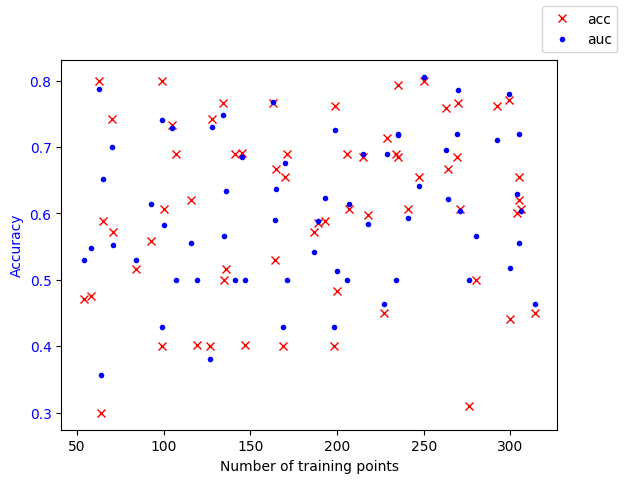

In [ ]:
# Trial 1 Plot 1
fig, ax1 = plt.subplots()
ax1.plot(size, acc_scores, 'rx', label = 'acc')
ax1.plot(size, auc_scores, 'b.', label = 'auc')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_E_scatter.png")

In [ ]:
from scipy.optimize import curve_fit
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=size, ydata=acc_scores, p0=[0.1, 0, 0.5], bounds=(-np.inf, np.inf))
pars

array([3.85686153e-01, 1.31277068e+12, 7.46272166e+00])

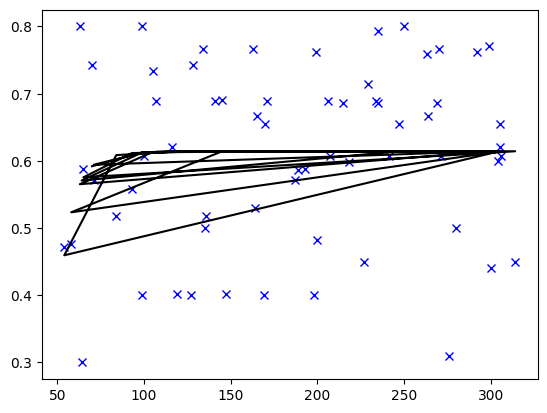

In [ ]:
# Trial 1 Plot 2
x = size
fig, ax1 = plt.subplots()
ax1.plot(x, acc_scores, 'bx')
ax1.plot(x, inverse_power(x, *pars), 'k-')

### Trial 2

In [ ]:
# Check new loop
# print(len(testlist))
for r in range(1, 21): #r: ratio of training folds
    sublist = testlist[:-1] #Training list
    # print(len(sublist))
    for i, x in enumerate(sublist):
      r_num = round(r / 20 * len(x))
      print(len(sublist[i]), r_num)
      sublist[i] = x[:r_num]
      print(len(sublist[i]))
    flattened_list = [num for x in sublist for num in x]
    print(len(flattened_list))

28 1
1
42 2
2
29 1
1
29 1
1
87 4
4
20 1
1
34 2
2
30 2
2
14
28 3
3
42 4
4
29 3
3
29 3
3
87 9
9
20 2
2
34 3
3
30 3
3
30
28 4
4
42 6
6
29 4
4
29 4
4
87 13
13
20 3
3
34 5
5
30 4
4
43
28 6
6
42 8
8
29 6
6
29 6
6
87 17
17
20 4
4
34 7
7
30 6
6
60
28 7
7
42 10
10
29 7
7
29 7
7
87 22
22
20 5
5
34 8
8
30 8
8
74
28 8
8
42 13
13
29 9
9
29 9
9
87 26
26
20 6
6
34 10
10
30 9
9
90
28 10
10
42 15
15
29 10
10
29 10
10
87 30
30
20 7
7
34 12
12
30 10
10
104
28 11
11
42 17
17
29 12
12
29 12
12
87 35
35
20 8
8
34 14
14
30 12
12
121
28 13
13
42 19
19
29 13
13
29 13
13
87 39
39
20 9
9
34 15
15
30 14
14
135
28 14
14
42 21
21
29 14
14
29 14
14
87 44
44
20 10
10
34 17
17
30 15
15
149
28 15
15
42 23
23
29 16
16
29 16
16
87 48
48
20 11
11
34 19
19
30 16
16
164
28 17
17
42 25
25
29 17
17
29 17
17
87 52
52
20 12
12
34 20
20
30 18
18
178
28 18
18
42 27
27
29 19
19
29 19
19
87 57
57
20 13
13
34 22
22
30 20
20
195
28 20
20
42 29
29
29 20
20
29 20
20
87 61
61
20 14
14
34 24
24
30 21
21
209
28 21
21
42 32
32
29 22
22
29 

In [ ]:
# Trial 2
from sklearn.model_selection import PredefinedSplit
import csv
base_path1 = f"{base}dataS/"
acc_scores = []
auc_scores = []
size = []
#Loop 0: Use different holdout/testing data set
for shuttle_i in range(len(testlist)):#len(testlist)-1
  print(f"Shuttle {shuttle_i}")
  best_params_list = []
  #Loop 1: training from 1/20 of each chr, increase the portion by each iteration
  for r in range(1, 21): #r: ratio of training folds
    sublist = testlist[:-1] #Training list
    # print(len(sublist))
    for i, x in enumerate(sublist):
      r_num = round(r / 20 * len(x))
      # print(len(sublist[i]), r_num)
      sublist[i] = x[:r_num]
      # print(len(sublist[i]))
    flattened_list = [num for x in sublist for num in x]
    size.append(len((flattened_list)))
    print(flattened_list)
    # print(f"Training with {n} folds; ")
    #1 Build training, validation and test sets/Extract individual index list
    train_v_indexes = flattened_list # Train with a ratio
    val_indexes = sublist[1] # For Shuttle i, always validate with first fold,
    test_indexes = testlist[-1] # and test with the last (same with the former optimisation-testing loop)
    X_train, y_train= X[train_v_indexes], Y[train_v_indexes]
    X_test, y_test= X[test_indexes], Y[test_indexes]
    print(f"training+validation size: {len(train_v_indexes)}; ", #{train_v_indexes},
        f"testing size: {len(test_indexes)}") #{test_indexes},

    #2 Use train and validation indexes to create the custom split
    # custom_split = [-1] * len(updated_trainlist[i]) + [0] * len(vlist[i])
    custom_split = [-1] * len(train_v_indexes)
    for i, x in enumerate(train_v_indexes):
      if x in val_indexes: custom_split[i] = 0
    # Initialize the PredefinedSplit object
    ps = PredefinedSplit(test_fold=custom_split)

    #3 Create model and optimise by BayesSearch
    model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
    opt = BayesSearchCV(
            model,
            param_space,
            n_iter=50,  # Number of iterations for optimization
            n_points=3,  # Number of points to sample in the hyperparameter space
            cv=ps,  # Number of cross-validation folds for inner optimization
            n_jobs=-1,  # Number of CPU cores to use (-1 for all cores)
            verbose=2
        )
    opt.fit(X_train, y_train)

    #4 Get the best hyperparameters found by the optimizer
    best_params = opt.best_params_
    best_params_list.append(best_params)
    print("Optimised paras: ", best_params, "; ")
    print("Iteration Best Score: {:.2f}%".format(100*opt.best_score_))

    #5 Create the XGBoost model with the best hyperparameters and fit it on the full training data
    xgb_model_best = create_xgboost_model(**best_params)
    xgb_model_best.fit(X_train, y_train)
    yhat = xgb_model_best.predict(X_test)

    #6 Calculate and store
    acc = accuracy_score(y_test, yhat)
    auc = roc_auc_score(y_test, yhat)
    acc_scores.append(acc)
    auc_scores.append(auc) #Typo: acc
    # ytrue_all.append(y_test)
    # yhat_all.append(yhat)
    # auc_scores.append(auc)
    print("Iteration Accuray: {:.2f}%".format(100*acc))
    print("Iteration AUC_ROC: {:.4f}".format(np.mean(auc)))
  #7 Loop for one holdout set finished
  #Reorder the testlist
  testlist = testlist[1:] + [testlist[0]]
  #Record best params
  with open(f"{base_path1}best_params_{shuttle_i}.csv", mode='w', newline='') as file:
        # Create a CSV writer object
        writer = csv.writer(file)
        # Write the list as a single row in the CSV file
        writer.writerow(best_params_list)
"""Note: the BayeSearchCV introduces randomness when search for the optimal hyperparameters."""
#8 Record data for scatter plot
def write_to_csv(file_path, data):
    with open(file_path, mode='w', newline='') as file:
      # Create a CSV writer object
      writer = csv.writer(file)
      # Write the list as a single row in the CSV file
      writer.writerow(data)
write_to_csv(f"{base_path1}acc_scores.csv", acc_scores)
write_to_csv(f"{base_path1}auc_scores.csv", auc_scores)
write_to_csv(f"{base_path1}size.csv", size)

Shuttle 0
[18, 62, 63, 115, 144, 145, 146, 147, 148, 239, 243, 244, 284, 285]
training+validation size: 14;  testing size: 35
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totall

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.01), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 1000), ('reg_alpha', 0), ('subsample', 1.0)]) ; 
Iteration Best Score: 85.19%
Iteration Accuray: 77.14%
Iteration AUC_ROC: 0.7500
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 49, 50, 51, 52, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 2

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.01), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 50), ('reg_alpha', 1), ('subsample', 0.1)]) ; 
Iteration Best Score: 87.50%
Iteration Accuray: 77.14%
Iteration AUC_ROC: 0.7500
[18, 19, 20, 21, 22, 23, 24, 25, 2

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.15209884330481294), ('max_depth', 10), ('min_child_weight', 20), ('n_estimators', 1000), ('reg_alpha', 1), ('subsample', 0.7485991998507036)]) ; 
Iteration Best Score: 82.50%
Iteration Accuray: 82.86%
Iteration AUC_ROC: 0.8200
[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 1.0), ('max_depth', 6), ('min_child_weight', 1), ('n_estimators', 381), ('reg_alpha', 0), ('subsample', 0.7936057094953147)]) ; 
Iteration Best Score: 100.00%
Iteration Accuray: 57.14%
Iteration AUC_ROC: 0.5729
[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 239, 240, 241, 242, 232, 233, 234, 235, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 317, 318, 319, 

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.01), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 1000), ('reg_alpha', 0), ('subsample', 1.0)]) ; 
Iteration Best Score: 91.67%
Iteration Accuray: 64.29%
Iteration AUC_ROC: 0.6458
[62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 239, 240, 241, 242, 232, 233, 234, 235, 236, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 317, 318, 319, 320, 321, 322, 

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 1.0), ('max_depth', 10), ('min_child_weight', 3), ('n_estimators', 494), ('reg_alpha', 0), ('subsample', 1.0)]) ; 
Iteration Best Score: 100.00%
Iteration Accuray: 69.05%
Iteration AUC_ROC: 0.6556
[115, 116, 117, 118, 119, 120, 144, 237, 238, 314, 315, 316, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 284, 285, 286, 287, 288, 289, 317, 318, 319, 320, 321, 322, 323, 18, 19, 20, 21, 22, 23]
training+validation size: 59;  testing size: 42
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totall

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.19404980498529542), ('max_depth', 7), ('min_child_weight', 1), ('n_estimators', 382), ('reg_alpha', 0), ('subsample', 0.5838728130143866)]) ; 
Iteration Best Score: 83.33%
Iteration Accuray: 73.81%
Iteration AUC_ROC: 0.6926
[115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 239, 240, 241, 242, 232, 233, 2

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 1.0), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 1000), ('reg_alpha', 0), ('subsample', 0.7539864143224815)]) ; 
Iteration Best Score: 85.71%
Iteration Accuray: 54.76%
Iteration AUC_ROC: 0.5296
[115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 239, 240, 241, 242, 232, 233, 234, 235, 236, 104, 105, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 317, 318, 319, 320, 321, 322, 323, 324

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.2174819138473748), ('max_depth', 1), ('min_child_weight', 2), ('n_estimators', 98), ('reg_alpha', 0), ('subsample', 0.9606649653427789)]) ; 
Iteration Best Score: 82.35%
Iteration Accuray: 82.76%
Iteration AUC_ROC: 0.7890
[144, 237, 238, 314, 315, 316, 277, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 239, 240, 241, 242, 232, 243, 244, 245, 246, 247, 248, 249, 250, 284, 285, 286, 287, 288, 289, 290, 291, 317, 318, 319, 320, 321, 322, 323, 324, 325, 18, 19, 20, 21, 22, 23, 24, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
training+validation size: 76;  testing size: 29
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fittin

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.8867919367842179), ('max_depth', 5), ('min_child_weight', 10), ('n_estimators', 60), ('reg_alpha', 0), ('subsample', 0.6331170140785722)]) ; 
Iteration Best Score: 81.25%
Iteration Accuray: 79.31%
Iteration AUC_ROC: 0.7175
[144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 49, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 239, 240, 241, 2

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.01), ('max_depth', 1), ('min_child_weight', 1), ('n_estimators', 697), ('reg_alpha', 1), ('subsample', 0.5671280972768961)]) ; 
Iteration Best Score: 85.25%
Iteration Accuray: 86.21%
Iteration AUC_ROC: 0.7143
[144, 237, 238, 314, 315, 316, 277, 278, 279, 280, 281, 282, 283, 46, 47, 48, 49, 50, 51, 52, 53, 54, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 239, 240, 241, 242, 232, 233, 234, 235, 236, 104, 105, 106, 107, 108, 109, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.02935790965134169), ('max_depth', 5), ('min_child_weight', 1), ('n_estimators', 50), ('reg_alpha', 0), ('subsample', 0.42497828847925945)]) ; 
Iteration Best Score: 80.00%
Iteration Accuray: 65.52%
Iteration AUC_ROC: 0.7194
[145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 239, 240, 241, 242, 232, 233, 234, 235, 236, 104, 105, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 1.0), ('max_depth', 6), ('min_child_weight', 2), ('n_estimators', 659), ('reg_alpha', 0), ('subsample', 0.49138081606344297)]) ; 
Iteration Best Score: 55.56%
Iteration Accuray: 55.17%
Iteration AUC_ROC: 0.5833
[145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 239, 240, 241, 242, 232, 233, 234, 235, 236, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 26

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.3055716541489084), ('max_depth', 6), ('min_child_weight', 4), ('n_estimators', 598), ('reg_alpha', 1), ('subsample', 0.9895257763903305)]) ; 
Iteration Best Score: 100.

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 1), ('learning_rate', 0.01282679135804629), ('max_depth', 4), ('min_child_weight', 9), ('n_estimators', 106), ('reg_alpha', 1), ('subsample', 0.48011303543977457)]) ; 
Iteration Best Score: 88.89%
Iteration Accuray: 30.00%
Iteration AUC_ROC: 0.5000
[243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 144, 237, 238, 314, 315, 316, 277, 

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 1 folds for each of 2 candidates, totalling 2 fits
Optimised paras:  OrderedDict([('gamma', 0), ('learning_rate', 0.3162877128988963), ('max_depth', 6), ('min_child_weight', 9), ('n_estimators', 907), ('reg_alpha', 1), ('subsample', 0.7987601765256803)]) ; 
Iteration Best Score: 100.00%
Iteration Accuray: 38.24%
Iteration AUC_ROC: 0.5000
[284, 285, 286, 287, 288, 289, 317, 318, 319, 320, 321, 322, 323, 18, 19, 20, 21, 22, 23, 62, 63, 64, 65, 66, 67, 68, 69, 115, 116, 117, 118, 119, 120, 144, 237, 238, 314, 315, 316, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 239, 240, 241, 242]
training+validation size: 60;  testing size: 34
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for each of 3 candidates, totalling 3 fits
Fitting 1 folds for ea

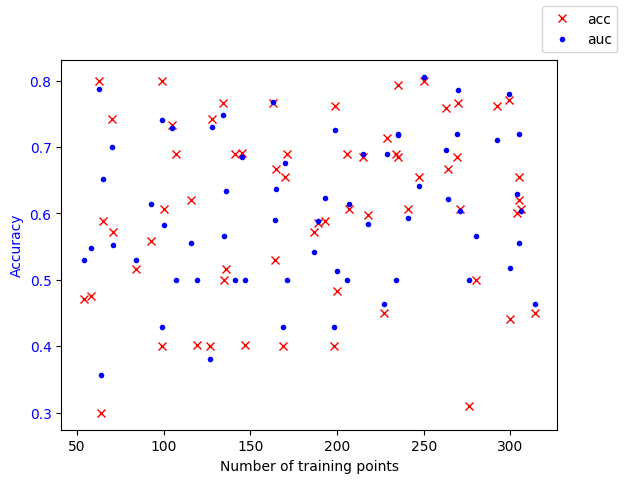

In [ ]:
# Trial 2 Plot 1
fig, ax1 = plt.subplots()
ax1.plot(size, acc_scores, 'rx', label = 'acc')
ax1.plot(size, auc_scores, 'b.', label = 'auc')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')
fig.legend()
plt.show()
fig.savefig(f"{base_path1}dataS_E_scatter.png")

In [ ]:
from scipy.optimize import curve_fit
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=size, ydata=acc_scores, p0=[0.1, 0, 0.5], bounds=(-np.inf, np.inf))
pars

array([3.85686153e-01, 1.31277068e+12, 7.46272166e+00])

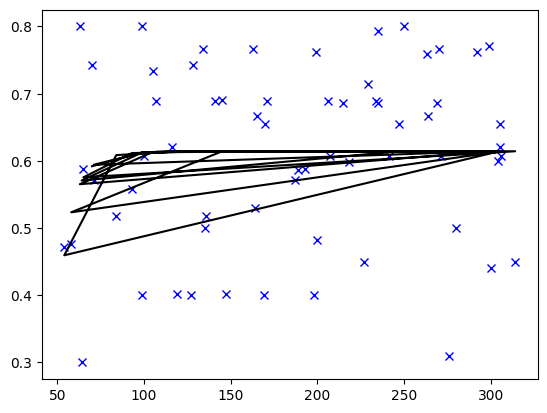

In [ ]:
# Trial 2 Plot 2
x = size
fig, ax1 = plt.subplots()
ax1.plot(x, acc_scores, 'bx')
ax1.plot(x, inverse_power(x, *pars), 'k-')

##*Archieved

In [ ]:
# New_classifier
n = 10
p1 = list()
mean_n_acc1 = list()
while n <= len(Ytrain):
  n_acc, judge = list(), list()
  for i in range(50):
    Xtrain_i = Xtrain[0:n]
    Ytrain_i = Ytrain[0:n]
    new_classifier.fit(Xtrain_i,Ytrain_i)
    yhat = new_classifier.predict(Xtest)
    # calculate accuracy
    acc = accuracy_score(Ytest, yhat)
    # compare with random classifier
    random_labels = np.random.choice([0, 1], size=len(Xtest))
    acc_r = accuracy_score(Ytest, random_labels)
    judge_i = acc <= acc_r # null hypothesis
    # store
    n_acc.append(acc)
    judge.append(judge_i)
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=n+i)
  #print(judge)
  p_T = sum(judge)/50
  mean_n_acc1.append(np.mean(n_acc))
  p1.append(p_T)
  n+=10
print(p1)
print(mean_n_acc1)

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(range(10,253,10), mean_n_acc1, 'bx-')
ax1.set_xlabel('Number of training points')
ax1.set_ylabel('Accuracy',color='b')
ax1.tick_params(axis='y',labelcolor='b')

In [ ]:
from scipy.optimize import curve_fit
x = list(range(10,253,10))
def inverse_power(x, a, b, c):
    return (1-a)-b*(x**(-c))
pars, cov = curve_fit(f=inverse_power, xdata=x, ydata=mean_n_acc1, p0=[0.1, 0.1, 0.5], bounds=(-np.inf, np.inf))
pars

In [ ]:
x = list(range(10,253,10))
fig, ax1 = plt.subplots()
ax1.plot(x, mean_n_acc1, 'bx')
ax1.plot(x, inverse_power(x, *pars), 'k-')

In [ ]:
a, b, c = pars[0], pars[1], pars[2]
def inv_inverse_power(y):
    return (((1-a)-y)/b)**(-1/c)
inv_inverse_power(0.6)

In [ ]:
# Sample code of "fsolve"
import numpy as np
from scipy.optimize import fsolve
def func(x):
    return [x[0] * np.cos(x[1]) - 4,
            x[1] * x[0] - x[1] - 5]
root = fsolve(func, [1, 1])
np.isclose(func(root), [0.0, 0.0])  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

In [ ]:
# find x that can result in 90% accuracy
from scipy.optimize import fsolve
def func(x):
    return inverse_power(x, *pars)
def difference(x):
    return func(x) - 0.9
root = fsolve(difference, 253) # Find the root when the function is shifted by 0.9, initial value = 253

print(np.isclose(func(root),0))  # func(root) should be almost 0.0.
print(root,'\n')
print(func(root))

## Conlusion for data size estimation:
The 0.6 bond for accuracy may be caused by: Disturbing (wrong) training data or two few training features.

## Active Learning

In [ ]:
!pip install modAL